### MobileNet

Сверточная часть интересующей нас сети состоит из одного обычного свёрточного слоя с 3х3 свёрткой в начале и тринадцати блоков с постепенно увеличивающимся числом фильтров и понижающейся пространственной размерностью тензора.

Особенностью данной архитектуры является отсутствие max pooling-слоёв. Вместо них для снижения пространственной размерности используется свёртка с параметром stride, равным 2.

Двумя гиперпараметрами архитектуры MobileNet являются $\alpha$ (множитель ширины) и $\rho$ (множитель глубины или множитель разрешения).

Множитель ширины отвечает за количество каналов в каждом слое. Например, $\alpha = 1$ даёт нам архитектуру, описанную в статье, а $\alpha = 0.25$ — архитектуру с уменьшенным в четыре раза числом каналов на выходе каждого блока.

Множитель разрешения отвечает за пространственные размеры входных тензоров. Например, $\rho= 0.5$ означает, что высота и ширина feature map, подаваемой на вход каждому слою будет уменьшена вдвое.

Оба параметра позволяют варьировать размеры сети: уменьшая $\alpha$ и $\rho$, мы снижаем точность распознавания, но в то же время увеличиваем скорость работы и уменьшаем потребляемую память.

Появление MobileNet уже само по себе сделало революцию в компьютерном зрении на мобильных платформах, однако в 2018г Google выложил в открытый доступ MobileNetV2 — следующее поколение нейросетей этого семейства, которое позволяет достигать примерно такой же точности распознавания при ещё большей скорости работы.

Основной строительный блок этой сети в целом похож на предыдущее поколение, но имеет ряд ключевых особенностей.

Как и в MobileNetV1, здесь есть сверточные блоки с шагом 1 (на рисунке слева) и с шагом 2 (на рисунке справа). Блоки с шагом 2 предназначены для снижения пространственной размерности тензора и, в отличие от блока с шагом 1, не имеют residual connections.


Блок MobileNet, называемый авторами расширяющим сверточным блоком (в оригинале expansion convolution block или bottleneck convolution block with expansion layer), состоит из трёх слоёв:

- Сначала идёт pointwise convolution с большим количеством каналов, называемый expansion layer. На входе этот слой принимает тензор размерности $D_f * D_f * C_{in}$, а на выходе выдает тензор $D_f * D_f * (t*C_{in})$, где $t$ — новый гиперпараметр, названный уровнем расширения (в оригинале expansion factor). Авторы рекомендуют задавать этому гиперпараметру значение от 5 до 10, где меньшие значения лучше работают для более маленьких сетей, а большие — для более крупных (в самой статье во всех экспериментах принимается $t = 6$).
Этот слой создает отображение входного тензора в пространстве большой размерности. Авторы называют такое отображение «целевым многообразием» (в оригинале «manifold of interest»)


- Затем идёт depthwise convolution с ReLU6-активацией. Этот слой вместе с предыдущим по сути образует уже знакомый нам строительный блок MobileNetV1. На входе этот слой принимает тензор размерности $D_f * D_f * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * (t*C_{in})$, где $s$ — шаг свертки (stride), ведь как мы помним, depthwise convolution не меняет число каналов.


- В конце идёт 1х1-свертка с линейной функцией активации, понижающая число каналов. Авторы статьи выдвигают гипотезу, что «целевое многообразие» высокой размерности, полученное после предыдущих шагов, можно «уложить» в подпространство меньшей размерности без потери полезной информации, что, собственно и делается на этом шаге (как можно увидеть по экспериментальным результатам, эта гипотеза полностью оправдывается). На входе такой слой принимает тензор размерности $(D_f/s) * (D_f/s) * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * C_{out}$, где $C_{out}$ — количество каналов на выходе блока. Фактически, именно третий слой в этом блоке, называемый bottleneck layer, и является основным отличием второго поколения MobileNet от первого.

Самым большим достижением из этих экспериментов мне кажется то, что сейчас сети, способные работать на мобильных устройствах, показывают accuracy выше, чем у VGG16.

Также, в статье про MobileNetV2 показываются весьма интересные результаты на других задачах. В частности, авторы демонстрируют, что SSDLite-архитектура для задачи object detection, использующая MobileNetV2 в свёрточной части, превосходит известный детектор реального времени YOLOv2 по точности на датасете MS COCO, при этом показывая в 20 раз большую скорость и в 10 раз меньший размер (в частности, на смартфоне Google Pixel сеть MobileNetV2 позволяет делать object detection с 5 FPS).

Оригинальная статья - https://arxiv.org/pdf/1704.04861.pdf

### В качестве практики возьму датасет персонажей из Симпсонов и буду делать модель классификации.

- У нас имеется 42 персонажа.
- Классы Очень не сблансированны.
- Т.к. классы в любом случае придется балансировать, то метрику будем брать accuracy

За основу возьму архитектуру MobileNet V2, т.к. она довольно шустрая, но и в тоже время довольно глубокая. Хотя также есть риск переобучить ее, также потому, что она может быть слишком сложной для такого малого кол-ва данных(размер 1 класса из 42 пимерно 2000 картинок). Попробуем сначала на предобученной модели, попробуем поразмараживать слои, посмотреть на скорость обучения. качество модели. Вероятно придется довольно глубоко размараживать, т.к. обучалась она на фотках imagenet, а тут векорные картинки. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
from random import randint
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from torchvision import transforms
from PIL import Image

## Подготовка данных.

#### В первую очередь данные сбалансируем. Алгоритм следующий:
- Смотрим все папки и выясняем максимально чилсло картинок в классе.
- Потом по очереди каждый класс смотрим и добавляем аугментированную картинку из имеющихся в классе, до тех пор пока количество не станет равным максимальному классу.

*Картинку физически сохраняем на диск в папку с классом

In [2]:
class Regularisation:
    def __init__(self,
                 directory='simpsons_dataset/train/'):

        self.dir_path = directory
        self.directory = os.listdir(path=os.path.join(self.dir_path))

        self.min_files = float('inf')
        self.max_files = float('-inf')

    @staticmethod
    def load_image(_file):
        image = Image.open(_file)
        image.load()

        return image, image.size

    def transform_image(self, file_):
        x, size = self.load_image(file_)

        transforms_train = transforms.Compose([
            transforms.RandomRotation(degrees=(-15, 15), expand=True),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop(size=size, scale=(0.5, 0.95)),
        ])

        x = transforms_train(x)

        x.save(str(file_)[:-4] + str(randint(1770, 7000)) + ".jpg", "JPEG")

    def find_max_min(self):

        df = pd.DataFrame(columns=['character', 'total pics'])

        for index, folder in enumerate(self.directory):

            files_num = len(os.listdir(path=os.path.join(self.dir_path + folder)))

            df.loc[index] = {'character': folder, 'total pics': files_num}

            if files_num > self.max_files:
                self.max_files = files_num

            if files_num < self.min_files:
                self.min_files = files_num

        print(df)

        print('--------'
              '\nmax is {0}'
              '\nmin is {1}'.format(self.max_files, self.max_files))

        time.sleep(5)

    def regularise(self):
        self.find_max_min()

        if self.max_files != self.min_files:

            for folder in tqdm(self.directory):

                files_num = len(os.listdir(path=os.path.join(self.dir_path + folder)))
                files = os.listdir(path=os.path.join(self.dir_path + folder))

                while files_num < self.max_files:

                    for file in files:
                        files_num = len(os.listdir(path=os.path.join(self.dir_path + folder)))

                        if files_num >= self.max_files:
                            break

                        else:
                            path = os.path.join(self.dir_path + folder + '/' + file)
                            self.transform_image(path)

In [3]:
regularisation = Regularisation()
regularisation.regularise()

                   character  total pics
0     abraham_grampa_simpson        2246
1              agnes_skinner        2246
2     apu_nahasapeemapetilon        2246
3              barney_gumble        2246
4               bart_simpson        2246
5               carl_carlson        2246
6   charles_montgomery_burns        2246
7               chief_wiggum        2246
8            cletus_spuckler        2246
9             comic_book_guy        2246
10                 disco_stu        2246
11            edna_krabappel        2246
12                  fat_tony        2246
13                       gil        2246
14      groundskeeper_willie        2246
15             homer_simpson        2246
16             kent_brockman        2246
17          krusty_the_clown        2246
18             lenny_leonard        2246
19               lionel_hutz        2246
20              lisa_simpson        2246
21            maggie_simpson        2246
22             marge_simpson        2246
23             m

### Загрузка данных

Для загрузки будем использовать утилиту `tf.keras.utils.image_dataset_from_directory`, т.к. загружаем физические картинки с диска.

In [4]:
PATH = 'simpsons_dataset/'
img_dir = os.path.join(PATH, 'train')

BATCH_SIZE = 64
IMG_SIZE = (256, 256)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(img_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split = 0.2,
                                                            subset='training',
                                                             seed=123)

Found 94332 files belonging to 42 classes.
Using 75466 files for training.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(img_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='categorical',
                                                                 validation_split = 0.2,
                                                                 subset='validation',
                                                                 seed=123)

Found 94332 files belonging to 42 classes.
Using 18866 files for validation.


Проверим картинки и лейблы:

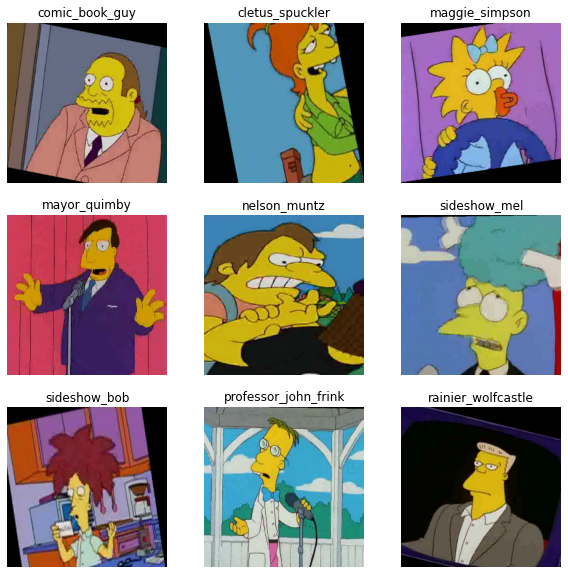

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

Также мы может ощипнуть кусок данных для конечного теста модели. Используем: `tf.data.experimental.cardinality`

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1180
Number of validation batches: 236
Number of test batches: 59


### Немного магии для ускорения загрузки

Метод для оптимизации загрузки данных в модель при обучении.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Стандартизация

Так как модель изначально обучалась на входных данных в диапазоне 1, -1, то и наши картинки нужно привести к этому виду. Вообще используя предобученные модели всегда стоит сперва посмотреть, какие данные они ждут на вход. ('[-1, 1]' или '[0, 1]')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Также для этого можно использовать простой метод `tf.keras.layers.Rescaling`.

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Загрузим предобученную модель

Если я правильно понял, обычно делают следующим образом: Загружают преобученную модель, заменяют последний слой классификации,
и дальше уже "доучивают" какуюто часть слоев, на свое усмотрение. Так мы и сделаем, загрузим модель без слоя классификации (include_top=False) и укажем, что веса должны быть из обучения на имеджнете (weights='imagenet'). 

Таким образом у нас получается, что мы используем предобученную модель для извлечения признаков из нашей картинки, а классифицируем их сами.

In [13]:
# Загрузка базовой предобученной модели MobileNet V2, не забываем указать размер входящей картинки.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

###### Т.е. картинка на входе `256x256x3` превращается в тензор признаков `8x8x1280` .

In [14]:
#Посмотрим, чтобы убедиться
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 8, 8, 1280)


## Базовый вариант

И так, базовый вариант: просто извлекаем признаки и классифицируем своим классификатором.

### Замораживаем предобученные веса

Важно сделать это до комприляции. Если мы хотим заморозить конкретные слои, то итерируемся по слоям и используем layer.trainable = False. Но т.к. в бозовом варианте мы замораживаем все слои то пишем просто  base_model.trainable = False


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 64, 64, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 16, 16, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 16, 16, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### Добавление нашего классификатора

На выходе сейчас мы имеем 1280 элементов 8x8, по идее можно сделать флаттенизацию, но тут мы возьмем усреднение.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


Добавим полносвязный слой с количеством выходжов = количеству классов. Софтмакс добавлять не будем, а просто укажем в лоссе, что мы подаем логиты.

In [18]:
prediction_layer = tf.keras.layers.Dense(42)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 42)


Соберем модель из всех словев.

In [19]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Компилируем модель


In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

Модель получилась довольно глубокой, однако параметров всего 2.3м, а обучаемых в данный момент всего 2 слоя.

In [22]:
len(model.trainable_variables)

2

### Тренировка


Можем посмотреть, что оно выдаст изначально. 

In [23]:

loss0, accuracy0 = model.evaluate(validation_dataset) 

236/236 [==============================] - 25s 93ms/step - loss: 4.2045 - accuracy: 0.0235


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 4.20
initial accuracy: 0.02


In [25]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
1180/1180 [==============================] - 140s 116ms/step - loss: 3.0145 - accuracy: 0.2451 - val_loss: 2.2512 - val_accuracy: 0.4932
Epoch 2/10
1180/1180 [==============================] - 137s 116ms/step - loss: 2.0425 - accuracy: 0.5029 - val_loss: 1.7112 - val_accuracy: 0.6171
Epoch 3/10
1180/1180 [==============================] - 138s 117ms/step - loss: 1.6511 - accuracy: 0.5978 - val_loss: 1.4391 - val_accuracy: 0.6732
Epoch 4/10
1180/1180 [==============================] - 160s 135ms/step - loss: 1.4322 - accuracy: 0.6522 - val_loss: 1.2721 - val_accuracy: 0.7061
Epoch 5/10
1180/1180 [==============================] - 170s 143ms/step - loss: 1.2929 - accuracy: 0.6830 - val_loss: 1.1583 - val_accuracy: 0.7302
Epoch 6/10
1180/1180 [==============================] - 171s 144ms/step - loss: 1.1943 - accuracy: 0.7033 - val_loss: 1.0755 - val_accuracy: 0.7472
Epoch 7/10
1180/1180 [==============================] - 170s 144ms/step - loss: 1.1180 - accuracy: 0.7224 - val_

### График обучения



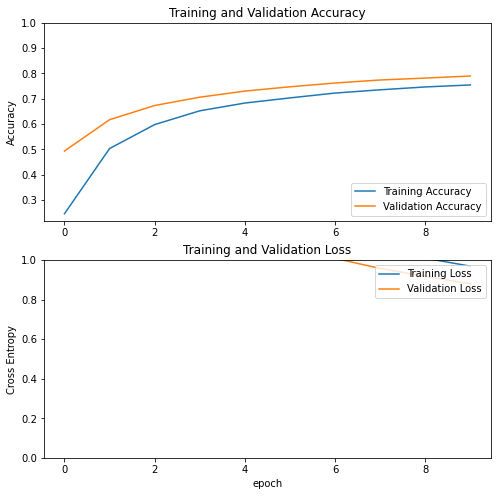

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



Видим, что качество растет, даже на предобученных весах, которые не видели наших Симпсонов.

### Разморозим слои для обучения


In [27]:
base_model.trainable = True

In [28]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 70

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### Снова соберем модель


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [31]:
len(model.trainable_variables)

88

### Продложим тренеровку

Укажем что учить надо продолжить с последней эпохи itial_epoch=history.epoch[-1]

In [32]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/40
1180/1180 [==============================] - 256s 210ms/step - loss: 0.2586 - accuracy: 0.4615 - val_loss: 0.2210 - val_accuracy: 0.5763
Epoch 11/40
1180/1180 [==============================] - 247s 209ms/step - loss: 0.2077 - accuracy: 0.5890 - val_loss: 0.1789 - val_accuracy: 0.6732
Epoch 12/40
1180/1180 [==============================] - 247s 209ms/step - loss: 0.1753 - accuracy: 0.6676 - val_loss: 0.1497 - val_accuracy: 0.7299
Epoch 13/40
1180/1180 [==============================] - 247s 209ms/step - loss: 0.1459 - accuracy: 0.7358 - val_loss: 0.1245 - val_accuracy: 0.7812
Epoch 14/40
1180/1180 [==============================] - 248s 210ms/step - loss: 0.1221 - accuracy: 0.7842 - val_loss: 0.1086 - val_accuracy: 0.8162
Epoch 15/40
1180/1180 [==============================] - 247s 209ms/step - loss: 0.1048 - accuracy: 0.8157 - val_loss: 0.0904 - val_accuracy: 0.8473
Epoch 16/40
1180/1180 [==============================] - 247s 209ms/step - loss: 0.0895 - accuracy: 0.8413

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

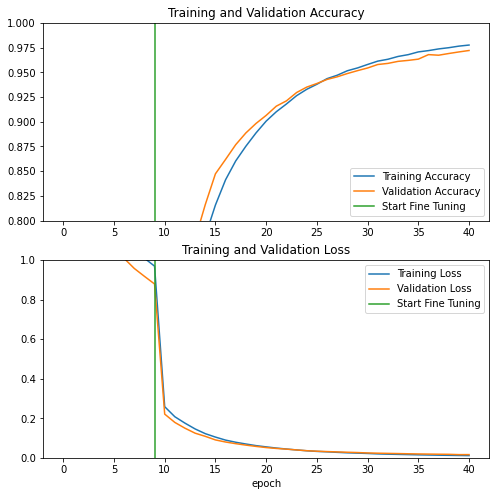

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Проверка на тестовых данных

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

59/59 [==============================] - 8s 124ms/step - loss: 0.0157 - accuracy: 0.9698
Test accuracy : 0.9698092937469482


In [42]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
for i, n in zip(predictions, label_batch):
    print(f'Predictions: {np.argmax(i)} - label: {np.argmax(n)}')


Predictions: 1 - label: 32
Predictions: 12 - label: 12
Predictions: 23 - label: 23
Predictions: 3 - label: 3
Predictions: 24 - label: 24
Predictions: 8 - label: 8
Predictions: 25 - label: 25
Predictions: 11 - label: 11
Predictions: 27 - label: 27
Predictions: 26 - label: 26
Predictions: 3 - label: 3
Predictions: 10 - label: 10
Predictions: 39 - label: 39
Predictions: 5 - label: 5
Predictions: 7 - label: 7
Predictions: 3 - label: 3
Predictions: 34 - label: 34
Predictions: 5 - label: 5
Predictions: 15 - label: 15
Predictions: 4 - label: 4
Predictions: 22 - label: 22
Predictions: 37 - label: 37
Predictions: 5 - label: 5
Predictions: 30 - label: 30
Predictions: 10 - label: 10
Predictions: 25 - label: 25
Predictions: 20 - label: 20
Predictions: 22 - label: 22
Predictions: 13 - label: 13
Predictions: 13 - label: 13
Predictions: 2 - label: 2
Predictions: 30 - label: 30
Predictions: 8 - label: 8
Predictions: 35 - label: 35
Predictions: 1 - label: 1
Predictions: 36 - label: 36
Predictions: 25 -

### Заключение

Как мы видим претренерованные модели очень хороший и быстрый вариант для создания моделей под свои нужды. Однако стоит понимать, что любая претренерованная модель видела только свой набор данных (как правило imagenet), и под свои данные придется переобучать глубокие слои абстракции. Несомненно плюсом является то, что обучать приходится не все параметры, что положительно влияет на скорость обучения.
Наша модель получилась довольно точной, при этом она практически не переобучилась, а точность также продолжает расти с эпохами. Т.е. мы можем еще доучить ее.